In [18]:
import onnxruntime as rt

In [19]:
sess = rt.InferenceSession("./vgg_unet_im_seg_base_ep20.onnx", providers=['CUDAExecutionProvider'])

In [20]:
input_name = sess.get_inputs()[0].name

In [21]:
print(input_name)

input


In [22]:
def get_image_array(image_input,
                    width, height,
                    imgNorm="sub_mean", ordering='channels_first', read_image_type=1):
    """ Load image array from input """

    if type(image_input) is np.ndarray:
        # It is already an array, use it as it is
        img = image_input
    elif isinstance(image_input, six.string_types):
        if not os.path.isfile(image_input):
            raise DataLoaderError("get_image_array: path {0} doesn't exist"
                                  .format(image_input))
        img = cv2.imread(image_input, read_image_type)
    else:
        raise DataLoaderError("get_image_array: Can't process input type {0}"
                              .format(str(type(image_input))))

    if imgNorm == "sub_and_divide":
        img = np.float32(cv2.resize(img, (width, height))) / 127.5 - 1
    elif imgNorm == "sub_mean":
        img = cv2.resize(img, (width, height))
        img = img.astype(np.float32)
        img = np.atleast_3d(img)

        means = [103.939, 116.779, 123.68]

        for i in range(min(img.shape[2], len(means))):
            img[:, :, i] -= means[i]

        img = img[:, :, ::-1]
    elif imgNorm == "divide":
        img = cv2.resize(img, (width, height))
        img = img.astype(np.float32)
        img = img/255.0

    if ordering == 'channels_first':
        img = np.rollaxis(img, 2, 0)
    return img

In [23]:
n_classes = 50
input_height = 320
input_width = 640
output_height = 160
output_width = 320

In [24]:
import cv2
inp = cv2.imread("dataset1/images_prepped_test/0016E5_07965.png",1)

In [25]:
import numpy as np

IMAGE_ORDERING = "channels_last"
x = get_image_array(inp, input_width, input_height,
                    ordering=IMAGE_ORDERING)

In [26]:
#image_data = image_data[np.newaxis, ...].astype(np.float32)

In [27]:
input_tensor= np.array(np.expand_dims(x,0), dtype=np.float32)

In [28]:
label_name = sess.get_outputs()[0].name

In [48]:
%%time

#detections = sess.run(output_names, {input_name: x})
detections = sess.run([label_name], {input_name: input_tensor})


CPU times: user 17 ms, sys: 20.7 ms, total: 37.7 ms
Wall time: 36.4 ms


In [31]:
arr = np.asarray(detections)

In [37]:
arr1 = np.squeeze(arr, axis=0)

SyntaxError: positional argument follows keyword argument (<ipython-input-37-dbf79787d6e6>, line 1)

In [38]:
arr2 = np.squeeze(arr1, axis=0)

In [39]:
arr2.shape

(51200, 50)

In [44]:
pr_p1 = arr2.reshape((output_height,  output_width, n_classes)).argmax(axis=2)

In [45]:
pr_p1.shape

(160, 320)

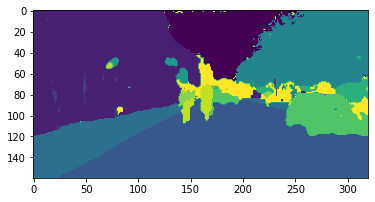

In [46]:
import matplotlib.pyplot as plt
plt.imshow(pr_p1)

In [40]:
arr3 = np.delete(arr, np.s_[1:3], axis=1)

In [43]:
arr3.shape

(1, 1, 51200, 50)